# Tree Structures

UXarry supports two different tree structures, BallTree and KDTree. These trees are tailored for neighbor searches, making them useful for spatial data queries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import uxarray as ux

For this example we will be using a UGRID meshfile

In [2]:
grid_path = "../../test/meshfiles/ugrid/quad-hexagon/grid.nc"
uxgrid = ux.open_grid(grid_path)

### BallTree

UXarray `BallTree` is built off of [sklearn.neighbors.BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html). A BallTree data structure organizes points in a multi-dimensional space into a tree of spheres. It is highly efficient for higher-dimensional data and for fast queries.

#### Parameters

The `BallTree` class can be accessed through the `Grid.get_ball_tree(coordinates, coordinate_system, distance_metric, reconstruct)` method, which takes in the following parameters:

* `coordinates` allows us to specify what nodes to build the tree on. We can choose from `nodes`, `face_centers`, or `edge_centers`. Each one will change how the tree is built. `nodes` builds the tree from the corner nodes of the grid, `face_centers` builds the tree from the face centers of each face, and `edge_centers` builds from the center of each edge in the grid. The default is to build from `nodes`. 
* `coordinate_system` specifies the tree's coordinate type when constructing. We can use either `cartesian`, which uses the `(x, y, z)` coordinate system, or `spherical`, which uses the `(lat, lon)` coordinate system. The default parameter is `spherical`.
* `distance_metric` relates to the distance computation, typically returned as a distance when querying for neighbors. There are a large number of options for us to use. A list of these options can be found [here](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.Grid.get_ball_tree.html). An important note here is that some distance metrics aren't compatible with some coordinate systems. `BallTree` uses the haversine distance as default, which will only work with spherical coordinates and not with cartesian. The default parameter is `haversine`.
* `reconstruct` is a bool variable that allows the user to reconstruct the tree. As default for performance, if a user calls `get_ball_tree` and a tree has already been created, it will simply use that one. If `reconstruct` is set to `True`, it will override this and reconstruct the tree. The default parameter is `False`.

#### Constructing a BallTree

We can store the BallTree data structure in a variable, which allows us to access the tree in a simple way for queries.

In [3]:
ball_tree = uxgrid.get_ball_tree(
    coordinates="nodes",
    coordinate_system="spherical",
    distance_metric="haversine",
    reconstruct="False",
)

#### Query

Now we can use that variable to query for the distance and indexes of the nearest neigbhors. The first parameter is the point from which to do the search. `return_distance` allows us to choose to return the distance of the neighbors, and `k` controls how many neighbors to find.

In [4]:
d, ind = ball_tree.query([0.0, 0.0], return_distance=True, k=1)

If we don't plan on using the tree for other things in the future we can skip the extra step and query right away

In [5]:
d, ind = uxgrid.get_ball_tree(
    coordinates="nodes",
    coordinate_system="spherical",
    distance_metric="haversine",
    reconstruct="True",
).query([0.0, 0.0], return_distance=True, k=1)

#### Query Radius

We can also query the tree using a radius search, instead of a nearest neighbor search. This allows us to get all points within a certain radius of a specific point. For spherical coordinates, the radius is in units of degrees, and for cartesian coordinates, the radius is in meters.

In [6]:
d, ind = ball_tree.query_radius([0.0, 0.0], r=5, return_distance=True)

### KDTree

The KDTree structure is a binary search tree useful for low-dimensional data. Its implementation is almost identical to BallTree, and the parameters are identical. An important note is that the different allowed inputs for `distance_metric` change between the trees. For KDTree allowed `distance_metrics` can be found [here](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.Grid.get_kd_tree.html). We can call it using `get_kd_tree()`. Generally, KDTree is going to be slower than BallTree, and it is recommended to use BallTree for most im

In [7]:
kd_tree = uxgrid.get_kd_tree()

`query()` and `query_radius()` work identically to the BallTree.

In [8]:
kd_tree.query([1.0, 0.0, 0.0], k=1)

(array(0.00208713), array(0))

In [9]:
kd_tree.query_radius([1.0, 0.0, 0.0], r=5, return_distance=True)

(array([0.00208713, 0.00274068, 0.00372471, 0.00455187]), array([0, 1, 2, 3]))

## R-tree for fast face candidate search

We build an rtree.index.Index over per-face axis-aligned bounding boxes (AABBs)
to quickly find candidate overlapping faces before exact intersection checks.
The index is built from `Grid.bounds` (in radians) and is accessible via `Grid.get_r_tree()`.
Use `list(tree.intersection(bounds))` to query for intersecting faces.
and pass `(xmin, ymin, xmax, ymax)` for 2D or `(xmin, ymin, zmin, xmax, ymax, zmax)` for 3D.


In [11]:
from uxarray.grid.r_tree import find_intersecting_face_pairs

# Tiny synthetic grid with two slightly overlapping faces
A = np.array([[29.5, 11.0], [29.5, 10.0], [30.5, 10.0], [30.5, 11.0]])
B = np.array([[30.0, 10.5], [30.0, 9.8], [31.0, 9.8], [31.0, 10.5]])
grid = ux.Grid.from_face_vertices([A, B], latlon=True)

# Build the per-face R-tree (or XY fallback) and query overlaps for face 0's box
rt = grid.get_r_tree()
arr = grid.bounds.values
lat_bounds = arr[:, 0, :]
lon_bounds = arr[:, 1, :]
from uxarray.grid.r_tree import face_aabb_xyz

boxes = face_aabb_xyz(lat_bounds, lon_bounds)
# For 3D trees, pass 6-tuple; for 2D trees, pass 4-tuple
tb = rt.bounds
query = (
    boxes[0] if len(tb) == 6 else (boxes[0][0], boxes[0][1], boxes[0][3], boxes[0][4])
)
cands = list(rt.intersection(query))
cands

[0, 1]

In [12]:
# Broad-phase candidate pairs via 3D AABB overlap
pairs = find_intersecting_face_pairs(grid.bounds)
pairs

array([[0, 1]])

## Plot R-tree hits on an MPAS/UGRID mesh (with face IDs)

Query the R-tree with a degenerate 3D bbox (x,y,z, x,y,z) via rtree.intersection - this gets the candidate face IDs whose AABBs hit the point. (This is a bbox prefilter; exact geometry checks could follow if needed.)

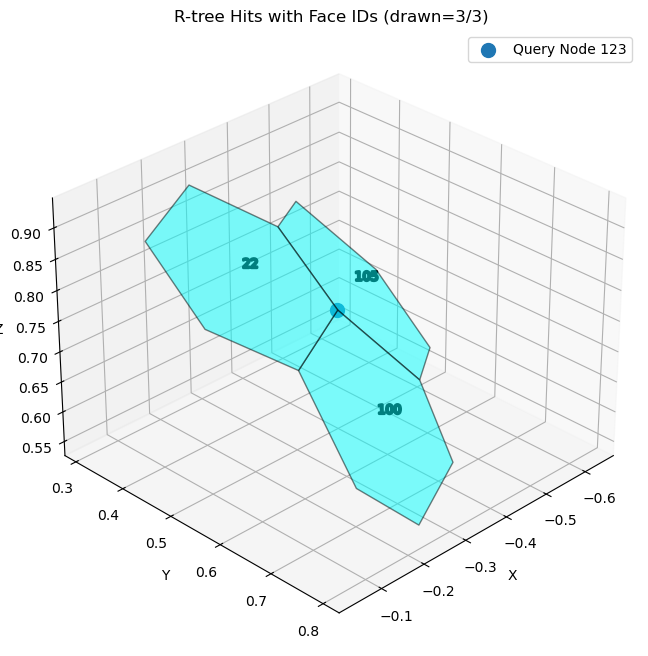

In [14]:
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from uxarray.grid.r_tree import construct_face_rtree_from_bounds

# --- IO & index ---
ugrid = ux.open_grid(
    "/nfs/lambda_stor_01/homes/jain/uxarray/test/meshfiles/mpas/QU/mesh.QU.1920km.151026.nc"
)
rtree, boxes, dim = construct_face_rtree_from_bounds(ugrid.bounds)

# Ensure face centroids are available (uses cartesian average; "welzl" also supported)
if not hasattr(ugrid, "face_x"):
    ugrid.construct_face_centers()  # default method="cartesian average"

# --- Query ---
node_id = 123
x, y, z = map(
    float, (ugrid.node_x[node_id], ugrid.node_y[node_id], ugrid.node_z[node_id])
)
hits = np.fromiter(rtree.intersection((x, y, z, x, y, z)), dtype=np.int64)

# --- Connectivity / coords ---
fnc = ugrid.face_node_connectivity.values
kpf = ugrid.n_nodes_per_face.values
nx, ny, nz = ugrid.node_x.values, ugrid.node_y.values, ugrid.node_z.values

# --- Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, s=100, label=f"Query Node {node_id}")
allV = []

for fid in hits:
    n = int(kpf[fid])
    idx = fnc[fid, :n]
    V = np.column_stack((nx[idx], ny[idx], nz[idx])).astype(float)
    if not np.allclose(V[0], V[-1]):
        V = np.vstack([V, V[0]])
    ax.add_collection3d(
        Poly3DCollection([V], alpha=0.5, facecolor="cyan", edgecolor="k")
    )
    # label at centroid with outward nudge along unit normal (≈ normalized centroid on unit sphere)
    c = np.array(
        [float(ugrid.face_x[fid]), float(ugrid.face_y[fid]), float(ugrid.face_z[fid])]
    )
    nrm = c / (np.linalg.norm(c) + 1e-15)
    cx, cy, cz = c + 0.01 * nrm
    txt = ax.text(cx, cy, cz, str(int(fid)), ha="center", va="center", fontsize=9)
    txt.set_path_effects([pe.withStroke(linewidth=2, foreground="black")])
    allV.append(V)

# bounds + cosmetics
P = np.vstack(allV)
pad = 0.06 * np.ptp(P, axis=0).max()
ax.set_xlim(P[:, 0].min() - pad, P[:, 0].max() + pad)
ax.set_ylim(P[:, 1].min() - pad, P[:, 1].max() + pad)
ax.set_zlim(P[:, 2].min() - pad, P[:, 2].max() + pad)
ax.view_init(30, 45)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"R-tree Hits with Face IDs (drawn={len(allV)}/{len(hits)})")
ax.legend()
plt.show()